In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import os, os.path
import pickle

In [2]:
src = cv2.imread('sample.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src = cv2.resize(src, dsize=(480, 640))

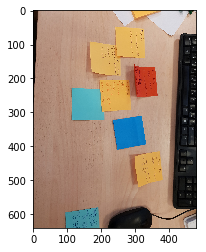

In [3]:
plt.imshow(src)
plt.show()

In [4]:
def calc_cmap_grad(mat):
    dx = mat[1:,1:]*1.0-mat[1:,:-1]*1.0
    dy = mat[1:,1:]*1.0-mat[:-1,1:]*1.0
    return dx, dy

def convert_grad_len_angle(dx, dy):
    glen = np.sqrt(dx * dx + dy * dy)
    gphi = np.arctan2(dy, dx)
    return glen, gphi

def filter_grads(g1, g2, min_v1=0, max_v1=np.inf):
    inds = (g1 >= min_v1) & (g1 < max_v1)
    return g1[inds], g2[inds]

def make_phi_buckets(num):
    phi_splits = np.hstack([-np.inf, np.linspace(-np.pi, np.pi, num + 1)[1:-1], np.inf])
    return list(zip(phi_splits[:-1], phi_splits[1:]))

def stat_grads(glen, gphi, min_len=0, max_len=np.inf, phi_buckets=[]):
    tlen, tphi = filter_grads(glen, gphi, min_len, max_len)
    phis = tphi.reshape(-1,1)
    return [len([phi for phi in phis if phi >= phi1 and phi < phi2]) for (phi1, phi2) in phi_buckets]

In [35]:
def calc_feature_def(mat1, mat2):
    m1 = np.mean(mat1, axis=(0,1))
    m2 = np.mean(mat2, axis=(0,1))
    s1 = np.std(mat1, axis=(0,1))
    s2 = np.std(mat2, axis=(0,1))
    
    ss1 = np.dot(s1, s1)
    ss2 = np.dot(s2, s2)
    d2 = np.dot(m1-m2,m1-m2)
    return np.sqrt(d2 / (ss1 + ss2))

def calc_feature_hor(mat):
    mid = mat.shape[0] >> 1
    return calc_feature_def(mat[:mid], mat[mid:])

def calc_feature_ver(mat):
    mid = mat.shape[0] >> 1
    return calc_feature_def(mat[:,:mid], mat[:,mid:])

In [145]:
def calc_diff(a, b):
    return np.sqrt(np.dot(a-b, a-b))

def calc_feature4(mat):
    mid = mat.shape[0] >> 1
    m1 = np.mean(mat[:mid, :mid], axis=(0,1))
    m2 = np.mean(mat[mid:, :mid], axis=(0,1))
    m3 = np.mean(mat[:mid, mid:], axis=(0,1))
    m4 = np.mean(mat[mid:, mid:], axis=(0,1))
    
    s1 = np.std(mat[:mid, :mid], axis=(0,1))
    s2 = np.std(mat[mid:, :mid], axis=(0,1))
    s3 = np.std(mat[:mid, mid:], axis=(0,1))
    s4 = np.std(mat[mid:, mid:], axis=(0,1))
    
    ss1 = np.sqrt(np.dot(s1, s1))
    ss2 = np.sqrt(np.dot(s2, s2))
    ss3 = np.sqrt(np.dot(s3, s3))
    ss4 = np.sqrt(np.dot(s4, s4))
    
    d12 = calc_diff(m1, m2)
    d13 = calc_diff(m1, m3)
    d14 = calc_diff(m1, m4)
    d23 = calc_diff(m2, m3)
    d24 = calc_diff(m2, m4)
    d34 = calc_diff(m3, m4)
    
    #print(d12, d13, d14, d23, d24, d34)
    
    p1 = np.min([d12, d13, d14])
    n1 = np.max([d23, d24, d34])
    
    p2 = np.min([d12, d23, d24])
    n2 = np.max([d13, d14, d34])
    
    p3 = np.min([d34, d13, d23])
    n3 = np.max([d12, d14, d24])
    
    p4 = np.min([d14, d24, d34])
    n4 = np.max([d12, d13, d23])
    
    #f1 = (p1 - n1) / ss1
    #f2 = (p2 - n2) / ss2
    #f3 = (p3 - n3) / ss3
    #f4 = (p4 - n4) / ss4
    
    f1 = (p1) / (ss1 + n1)
    f2 = (p2) / (ss2 + n2)
    f3 = (p3) / (ss3 + n3)
    f4 = (p4) / (ss4 + n4)
    
    return f1, f2, f3, f4

In [5]:
t1, t2 = calc_cmap_grad(src)

In [121]:
tmp = src.astype(float) / 255.0
mns = (tmp[1:,1:]+tmp[1:,:-1]+tmp[:-1,1:]+tmp[:-1,:-1]) / 4
sts0 = (tmp[1:,1:]-mns)**2+(tmp[1:,:-1]-mns)**2+(tmp[:-1,1:]-mns)**2+(tmp[:-1,:-1]-mns)**2
sts1 = np.sqrt(sts0[:,:,0]+sts0[:,:,1]+sts0[:,:,2])/3

In [119]:
mns.dtype

dtype('float64')

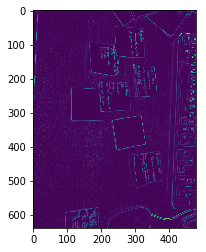

In [124]:
plt.imshow(sts1)
plt.show()

In [6]:
tl, tphi = convert_grad_len_angle(t1, t2)

In [13]:
phi_buckets = make_phi_buckets(16)
stat_grads(tl[224:234, 109:119], tphi[224:234, 109:119], min_len=20, phi_buckets=phi_buckets)

[2, 0, 6, 6, 3, 0, 0, 2, 8, 2, 0, 7, 3, 0, 1, 6]

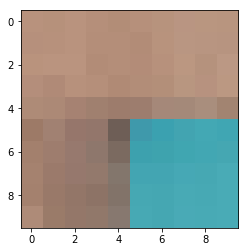

In [94]:
plt.imshow(src[224:234, 109:119])
plt.show()

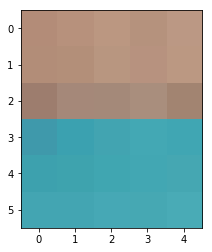

In [19]:
plt.imshow(src[226:232, 114:119])
plt.show()

In [43]:
%%time
max_y = src.shape[0] - 8
max_x = src.shape[1] - 8

ny = int(max_y/2)
nx = int(max_x/2)
res = np.zeros(shape=[ny, nx,2])
#print(res.shape)
for y in range(0, max_y, 2):
    for x in range(0, max_x, 2):
        f1 = calc_feature_hor(src[y:(y+8), x:(x+8)])
        f2 = calc_feature_ver(src[y:(y+8), x:(x+8)])
        iy = int(y/2)
        ix = int(x/2)
        res[iy,ix,:] = np.array([f1, f2])
        #if f > 5:
         #   print(f)
         #   plt.imshow(src[y:(y+10), x:(x+10)])
         #   plt.show()

Wall time: 17.5 s


In [86]:
%%time
max_y = res.shape[0] - 4
max_x = res.shape[1] - 4

ny = int(max_y/2)
nx = int(max_x/2)
res_f = np.zeros(shape=[ny, nx])
#print(res.shape)
for y in range(0, max_y, 2):
    for x in range(0, max_x, 2):
        fm = np.prod(np.max(res[y:(y+6), x:(x+6)], axis=(0,1)))
        iy = int(y/2)
        ix = int(x/2)
        res_f[iy,ix] = fm

Wall time: 236 ms


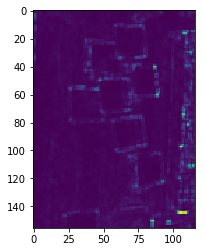

In [87]:
plt.imshow(res_f)
plt.show()

In [148]:
max_y = src.shape[0] - 10
max_x = src.shape[1] - 10

for y in range(0, max_y, 1):
    for x in range(0, max_x, 1):
        f1, f2, f3, f4 = calc_feature4(src[y:(y+10), x:(x+10)])
        if np.max([f1,f2,f3,f4]) > 4:
            print(f1,f2,f3,f4)
            plt.imshow(src[y:(y+10), x:(x+10)])
            plt.show()

KeyboardInterrupt: 

In [146]:
calc_feature4(src[224:234, 109:119])

(0.03466591746055881,
 0.27385681828972536,
 0.03400288559690754,
 2.37363228336364)

In [76]:
f1,f2,f3,f4

[(-inf, -2.356194490192345),
 (-2.356194490192345, -1.5707963267948966),
 (-1.5707963267948966, -0.7853981633974483),
 (-0.7853981633974483, 0.0),
 (0.0, 0.7853981633974483),
 (0.7853981633974483, 1.5707963267948966),
 (1.5707963267948966, 2.356194490192345),
 (2.356194490192345, inf)]

In [86]:
np.mean(src[:10,:10], axis=(0,1))

array([36.79, 19.52, 10.56])

In [87]:
np.max([1,2],[3,4],[-1,2])

TypeError: output must be an array